# El Salvador country profile

In [1]:
import os, sys, glob, json
os.chdir('../gscd/notebook/')
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('../data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:3857' # EI Salvador
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/SV_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    fn = fn.replace('\\', '/')
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
# auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'El Salvador',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionfacts/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1841	 | SV1841A1 | 14	| nan	| 0	| nan	| 0	|
| 2007	 | SV2007A1 | 14	| SV2007A2	| 262	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #


# 1. Default setting
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# 2. Manual setting
# a) Add admin names to reporting units
admin_level = 'admin_1'
reporting_unit = df.loc[df['fnid'].map(lambda x: x[6] != 'A'), 'fnid'].unique()
df.loc[df.fnid.isin(reporting_unit),admin_level] = df.loc[df.fnid.isin(reporting_unit), 'locality_name'].map(lambda x: x.split(',')[0])

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([SV_Admin1_1841, SV_Admin1_2007], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 3,148
Removed 808 "Missing Value" points
0/787 "Area Harvested" points are retained.
780/787 "Area Planted" points are retained.
780/787 "Quantity Produced" points are retained.
780/787 "Yield" points are retained.
Current data points: 2,340

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1997 - 2017
3 grain types are found: Maize Grain (White), Rice (Paddy), Sorghum (White)
4 seasons are found: Annual harvest (04-01), Postrera (09-01), Primera (05-01), Apante (11-01)
1 crop production system are found: none
Data sources include:
[1] Ministerio de Agricultura y Ganaderia, El Salvador --- Anuario de Estadisticas Agropecuaria, El Salvador
[2] Ministerio de Agricultura y Ganaderia, El Salvador --- Official agricultural statistics, El Salvador
Administrative-1 fnids: 14
Administrative-2 fnids: 0
0 reporting units are found: 

- Total production over tim

## El Salvador
El Salvador crop seasonal calendar

![FEWS NET](https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-el-salvador.png?itok=U0Gby9Kf)

![USDA](https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/ca_es_calendar.png)

- comparison of boundaries
![image](../figures/SV_admin_shapes.png)

- FDW data consists of `SV1841A1`.

- FEWS NET admin shapefiles ------------------- #

| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |:---:  |:---:  |
| 1841	 | SV1841A1 | 14	| nan	| 0	| nan	| 0	|
| 2007	 | SV2007A1 | 14	| SV2007A2	| 262	| nan	| 0	|

- **`SV1841A11`** is used to represent the current admin-level 1 crop data.
- El Salvador has four crop seasons: `Annual harvest`, `Postrera`, `Apante`, `Primera`.
- El Salvador has one crop production system: `none`.

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = SV_Admin1_1841.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

# Link admin boundaries ------------------------- #
link, over = FDW_PD_CreateAdminLink(SV_Admin1_1841, SV_Admin1_1841
                                    , 'ADMIN1', 'ADMIN1', prod, epsg)
# Crop specific ratios
link_ratio = FDW_PD_RatioAdminLink(link, prod, over, mdx_pss)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

In [5]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack_gscd = stack[names]
stack_gscd['gscd_code'] = 'calibrated'
# ----------------------------------------------- #

# Reported FDW data ----------------------------- #
stack_fdw = df[names]
stack_fdw['indicator'] = stack_fdw['indicator'].replace({'Area Harvested':'area','Quantity Produced':'production','Yield':'yield'})
stack_fdw['gscd_code'] = 'reported'
# ----------------------------------------------- #

# Final Processing ------------------------------ #
stack = pd.concat([stack_fdw,stack_gscd], axis=0).reset_index(drop=True)
# No concerns found for grain types
stack['product'] = stack['product'].replace(product_category)
# Calibration of planting and Harvest year and season
cs = {
    'Annual harvest': {'planting_month':{'04-01':'04-01'},'harvest_month':{'03-01':'03-01'}},
    'Postrera': {'planting_month':{'09-01':'09-01'},'harvest_month':{'12-01':'12-01'}},
    'Primera': {'planting_month':{'05-01':'05-01'},'harvest_month':{'08-01':'08-01'}},
    'Apante': {'planting_month':{'11-01':'11-01'},'harvest_month':{'02-01':'02-01'}},
}
cy = {}
stack, df, link_ratio = FDW_PD_CaliSeasonYear(stack, df, link_ratio, cs, cy)
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #
# Save data
save_hdf('../data/crop/adm_crop_production_SV.hdf', stack)
save_hdf('../data/crop/adm_crop_production_SV_raw.hdf', df)
save_npz('../data/crop/adm_crop_production_SV_ratio.npz', link_ratio)

../data/crop/adm_crop_production_SV.hdf is saved.
../data/crop/adm_crop_production_SV_raw.hdf is saved.
../data/crop/adm_crop_production_SV_ratio.npz is saved.


../figures/SV_bar_natgrainprod_Annual harvest.png is saved.
../figures/SV_bar_natgrainprod_Postrera.png is saved.


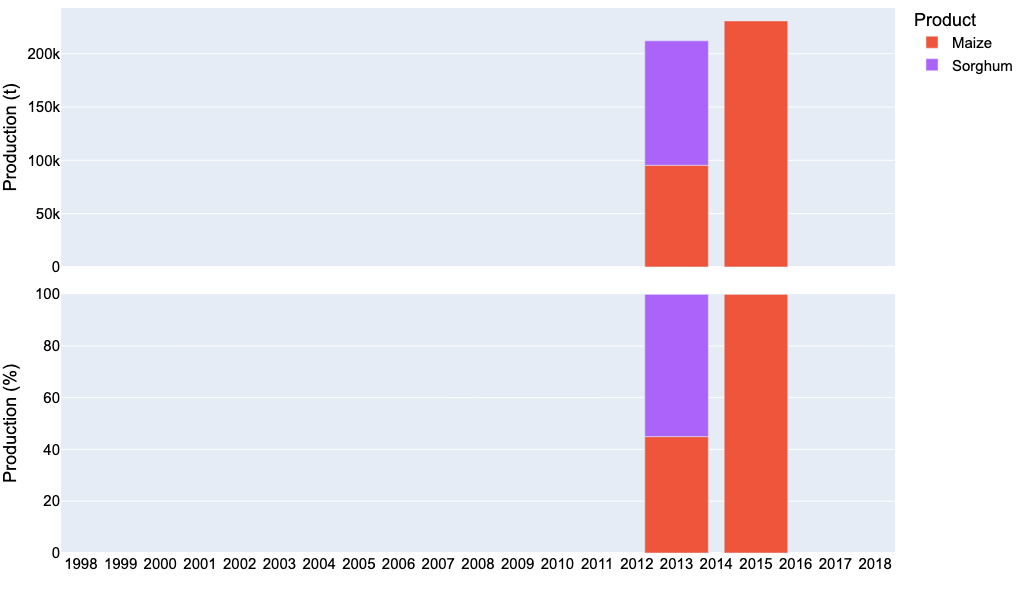

../figures/SV_bar_natgrainprod_Primera.png is saved.


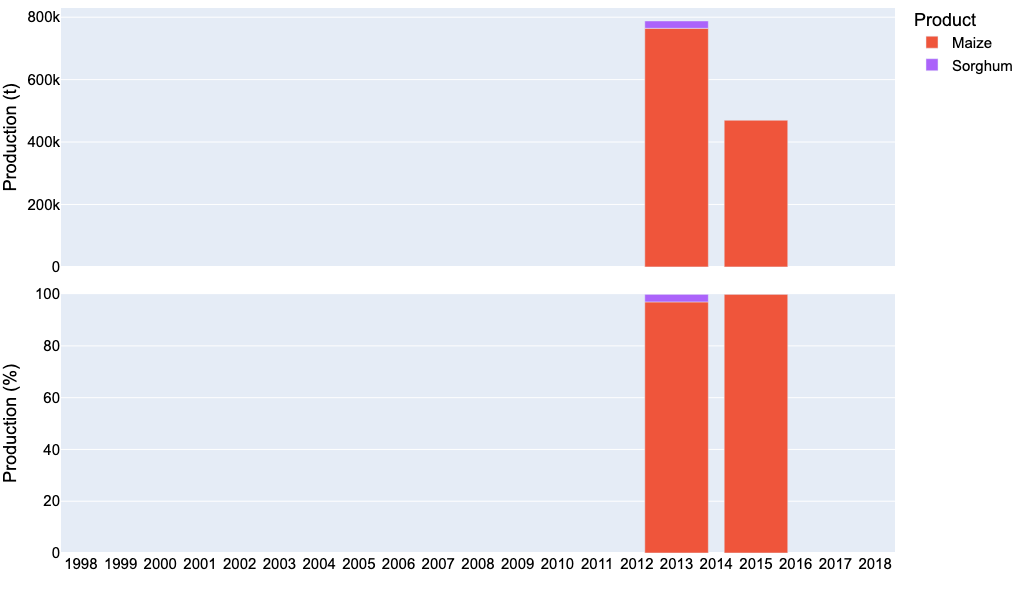

../figures/SV_bar_natgrainprod_Apante.png is saved.


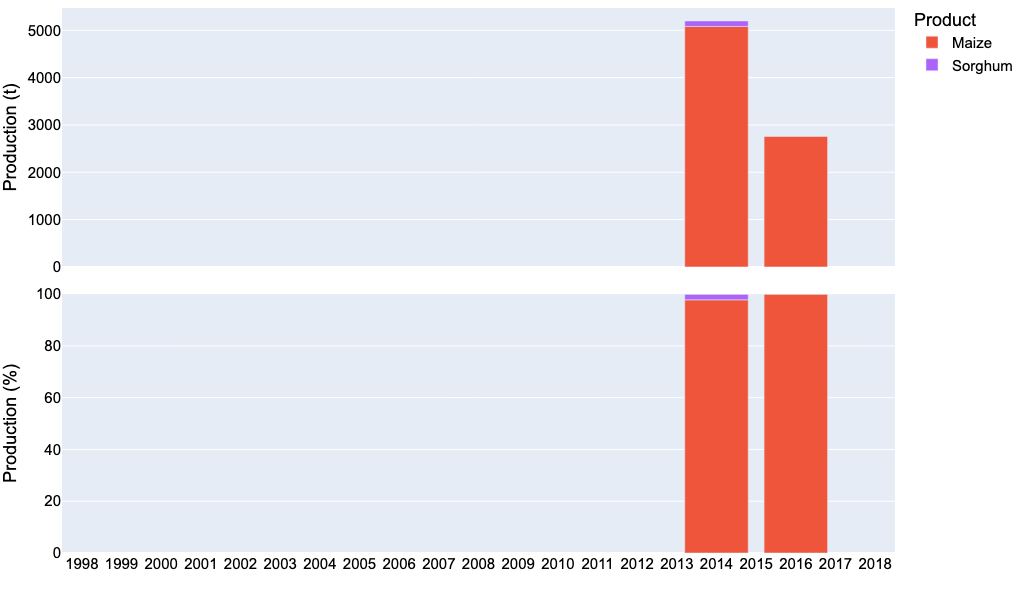

In [6]:


# Bar chart of national grain production
country_iso, country_name = 'SV', 'El Salvador'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Sorghum (White)','Maize','Rice']
for season_name in ['Annual harvest', 'Postrera', 'Primera', 'Apante']:
    footnote = 'National grain production in %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    if len(sub)==0:
        continue
    fig = PlotBarProduction(sub, year, product_order, footnote, fn_save)
    fig.show()

../figures/SV_line_pay_Maize_Primera.png is saved.


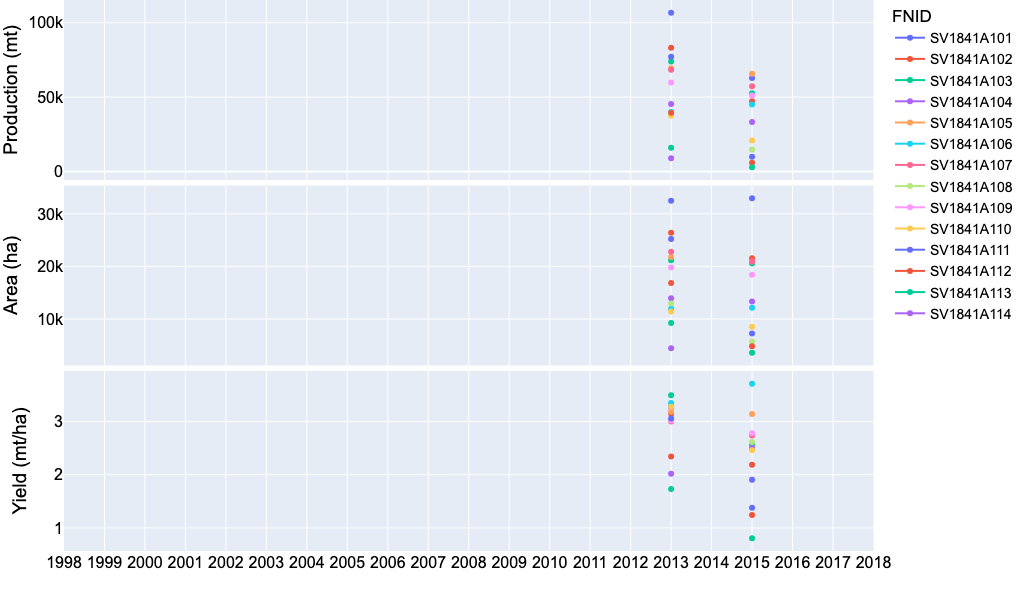

../figures/SV_line_pay_Maize_Postrera.png is saved.


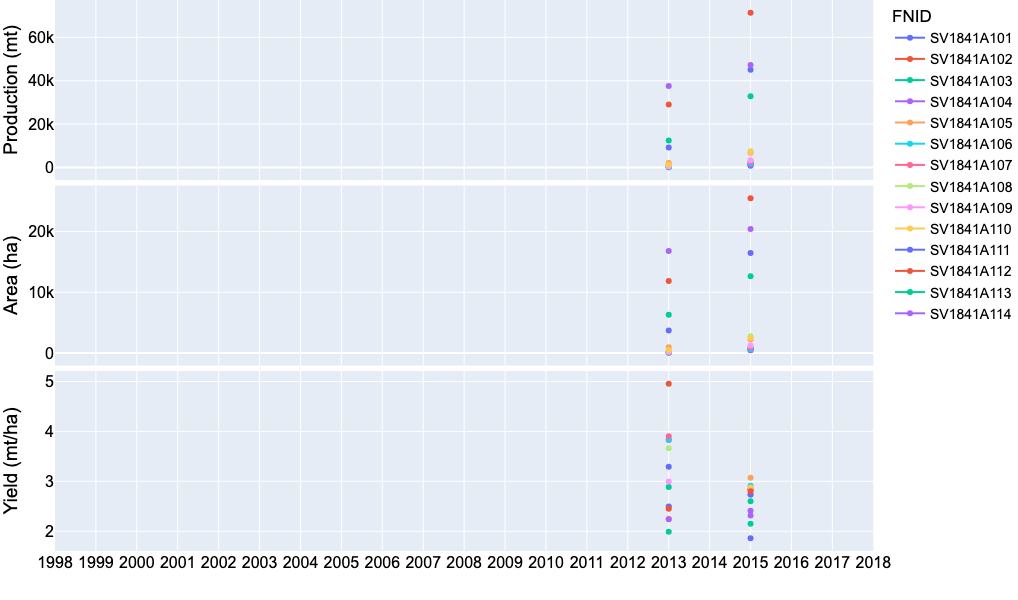

../figures/SV_line_pay_Maize_Apante.png is saved.


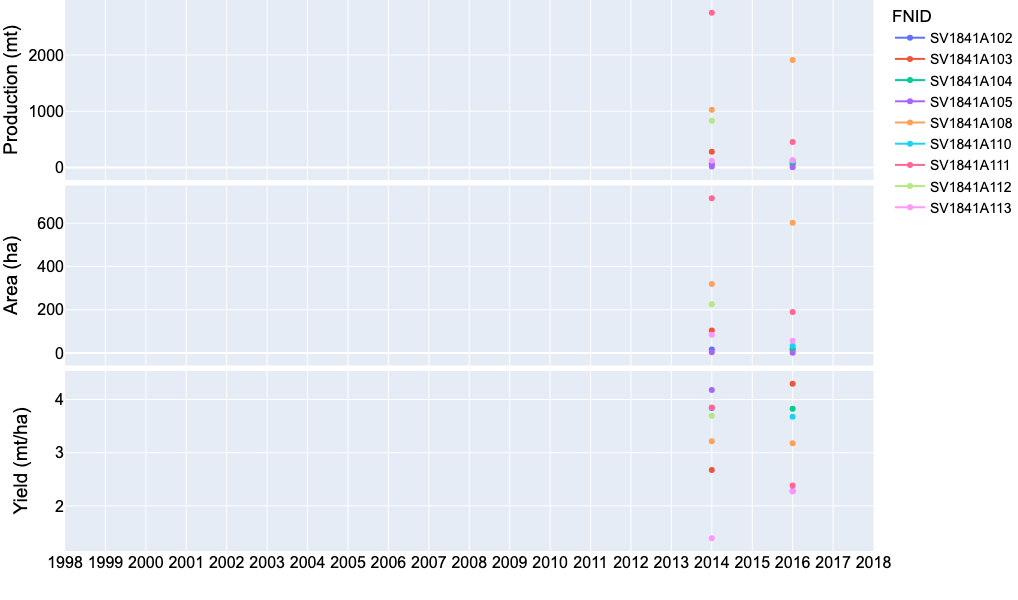

../figures/SV_line_pay_Maize_Annual harvest.png is saved.


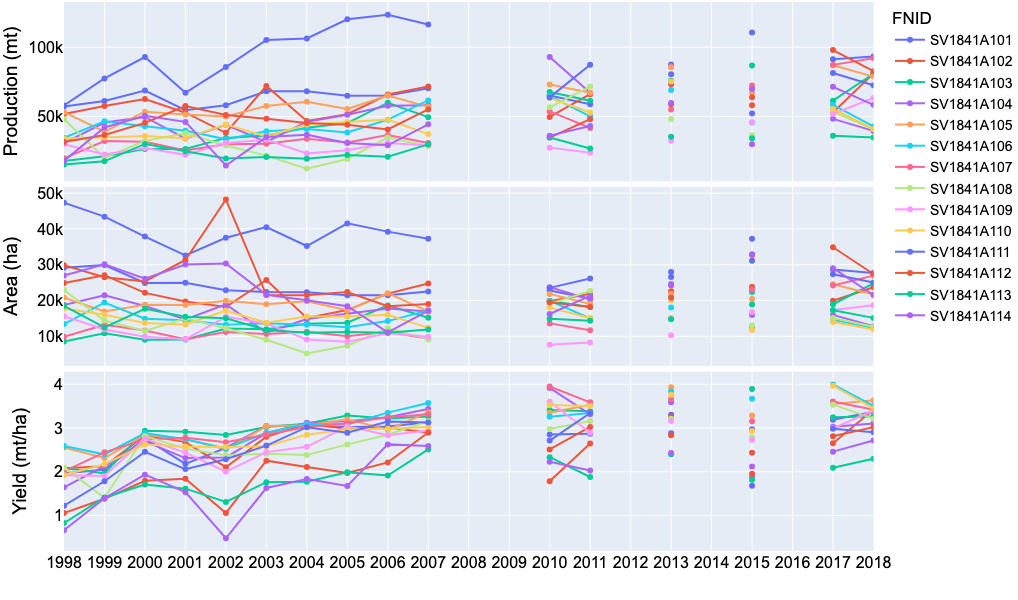

../figures/SV_line_pay_Rice_Annual harvest.png is saved.


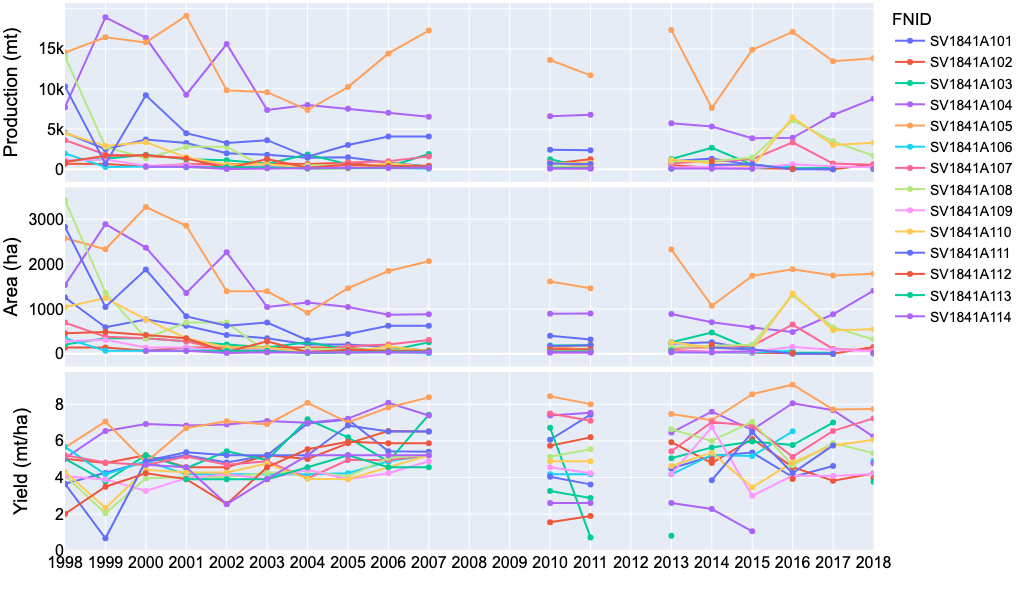

../figures/SV_line_pay_Sorghum_Postrera.png is saved.


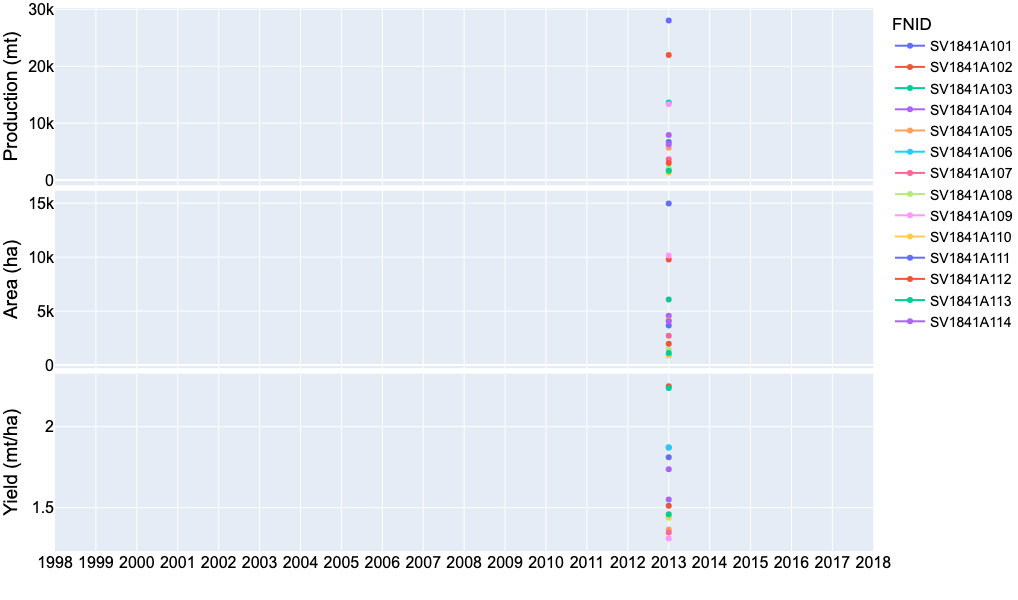

../figures/SV_line_pay_Sorghum_Apante.png is saved.


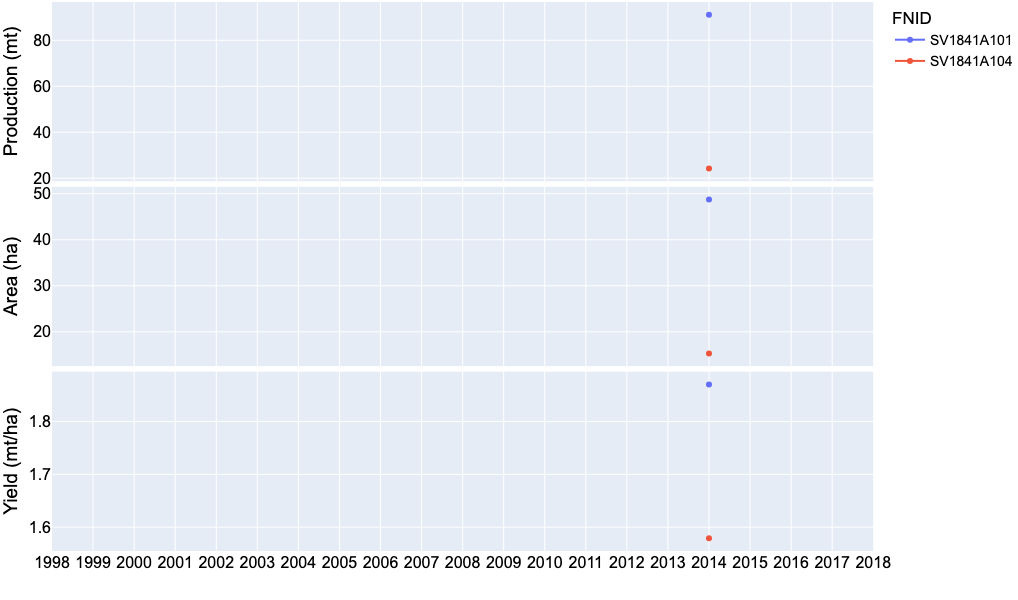

../figures/SV_line_pay_Sorghum_Primera.png is saved.


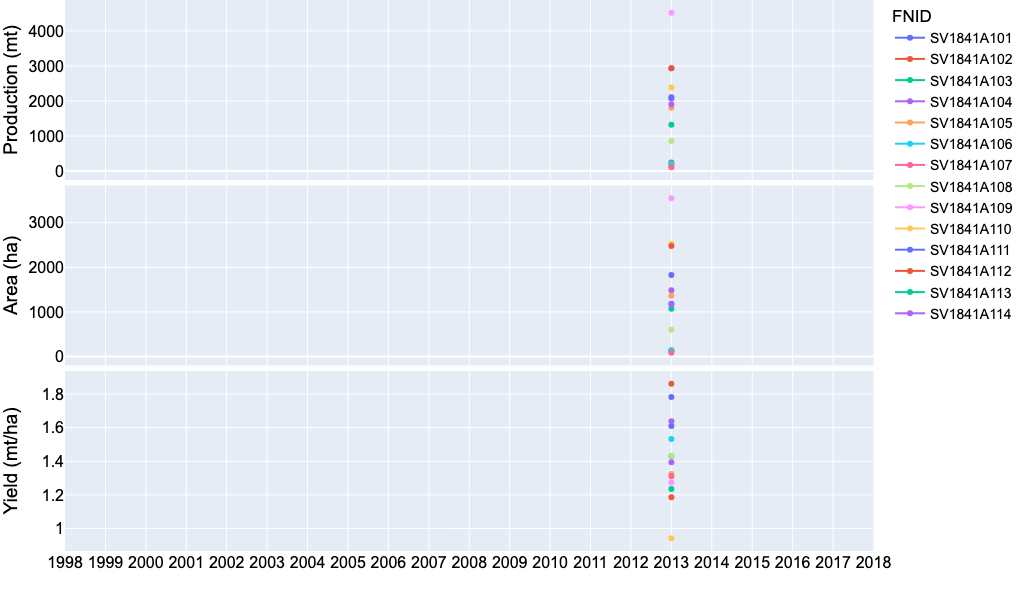

../figures/SV_line_pay_Sorghum_Annual harvest.png is saved.


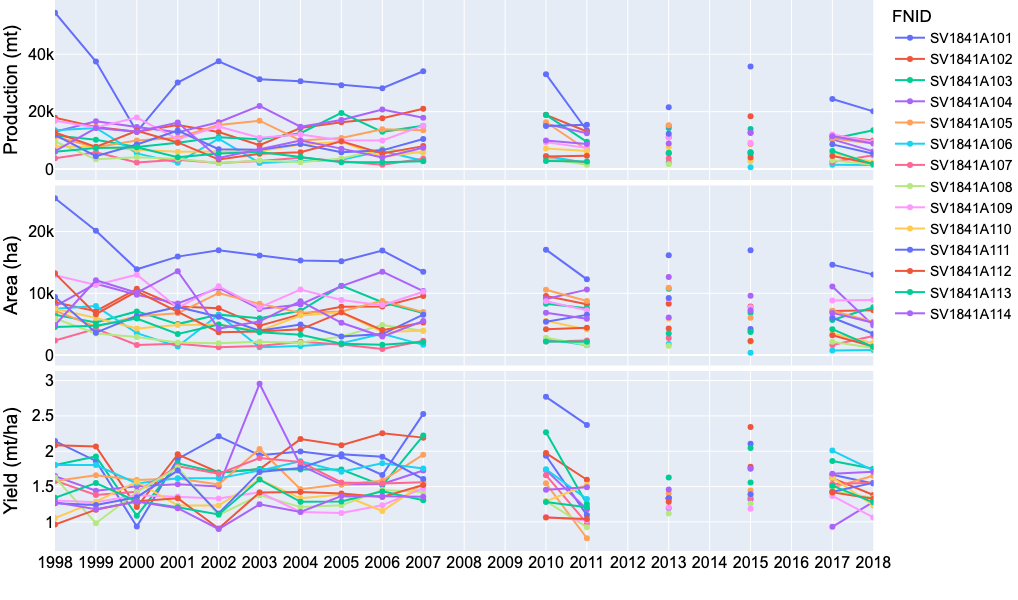

In [7]:
# Lineplot of Production-Area-Yield (PAY) time-series
country_iso, country_name = 'SV', 'El Salvador'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize','Primera'],
    ['Maize','Postrera'],
    ['Maize','Apante'],
    ['Maize','Annual harvest'],
    ['Rice','Annual harvest'],
    ['Sorghum','Postrera'],
    ['Sorghum','Apante'],
    ['Sorghum','Primera'],
    ['Sorghum','Annual harvest'],
]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield (PAY) time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    if len(sub)==0:
        continue
    fig = PlotLinePAY(sub, year, footnote, fn_save)
    fig.show()

In [8]:
# Calibrated PAY time-series per FNID
from tools_graphic import PlotLineCropTS
country_iso, country_name = 'SV', 'El Salvador'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
link_ratio = load_npz('../data/crop/adm_crop_production_%s_ratio.npz' % country_iso)
year_all = np.arange(df['year'].min(), df['year'].max()+1)
prod_season = [
    ['Maize','Primera'],
    ['Maize','Postrera'],
    ['Maize','Apante'],
    ['Maize','Annual harvest'],
    ['Rice','Annual harvest'],
    ['Sorghum','Postrera'],
    ['Sorghum','Apante'],
    ['Sorghum','Primera'],
    ['Sorghum','Annual harvest'],
]
for product_name, season_name in prod_season:
    sub = df[
        (df['product'] == product_name) &
        (df['season_name'] == season_name)
    ]
    for fnid in sub['fnid'].unique():
        sub_fps = sub[sub['fnid'] == fnid]
        fn_save = '../figures/crop_calibrated/%s_%s_%s_%s.png' % (country_iso, product_name, season_name, fnid)
        fig = PlotLineCropTS(sub_fps, fnid, product_name, season_name, link_ratio, year_all, fn_save)



../figures/crop_calibrated/SV_Maize_Primera_SV1841A101.png is saved.
../figures/crop_calibrated/SV_Maize_Primera_SV1841A102.png is saved.
../figures/crop_calibrated/SV_Maize_Primera_SV1841A103.png is saved.
../figures/crop_calibrated/SV_Maize_Primera_SV1841A104.png is saved.
../figures/crop_calibrated/SV_Maize_Primera_SV1841A105.png is saved.
../figures/crop_calibrated/SV_Maize_Primera_SV1841A106.png is saved.
../figures/crop_calibrated/SV_Maize_Primera_SV1841A107.png is saved.
../figures/crop_calibrated/SV_Maize_Primera_SV1841A108.png is saved.
../figures/crop_calibrated/SV_Maize_Primera_SV1841A109.png is saved.
../figures/crop_calibrated/SV_Maize_Primera_SV1841A110.png is saved.
../figures/crop_calibrated/SV_Maize_Primera_SV1841A111.png is saved.
../figures/crop_calibrated/SV_Maize_Primera_SV1841A112.png is saved.
../figures/crop_calibrated/SV_Maize_Primera_SV1841A114.png is saved.
../figures/crop_calibrated/SV_Maize_Primera_SV1841A113.png is saved.
../figures/crop_calibrated/SV_Maiz